# Phase 4 Project Notebook
- Author: Jonathan Holt
- Data Science Flex

## Business Problem
- What are the top 5 best zip codes for us to invest in?

## Questions to Answer

1. What is the average (mean) home price for zip codes?
    a. also by: State, Metro Region, etc.
2. Which zip codes performed above expectations?
3. Do the top performing zip codes have any identifiers?


## What Models & Metrics I plan on using

## Helper Functions
- Functions provided by Flatiron

In [1]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [40]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

## Loading Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import seaborn as sns

plt.style.use('seaborn')
pd.set_option('display.max_rows', 1000) #change the amount of rows displayed

In [4]:
df = pd.read_csv("zillow_data.csv")

In [5]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Checking for Null Values

In [8]:
df.isnull().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
1997-05       1039
1997-06       1039
1997-07       1038
1997-08       1038
1997-09       1038
1997-10       1038
1997-11       1038
1997-12       1038
1998-01       1036
1998-02       1036
1998-03       1036
1998-04       1036
1998-05       1036
1998-06       1036
1998-07       1036
1998-08       1036
1998-09       1036
1998-10       1036
1998-11       1036
1998-12       1036
1999-01       1036
1999-02       1036
1999-03       1036
1999-04       1036
1999-05       1036
1999-06       1036
1999-07       1036
1999-08       1036
1999-09       1036
1999-10       1036
1999-11       1036
1999-12       1036
2000-01     

### Analysis
There are many Null Values. 
- For categorical data, 7% of Metro are null (1043 of 14,723).
- Dates from 1996 - mid 2003, also have 7% null values.
- Then it starts to get better. 6% null and decreasing.

What is my decision on null values?
- keep?
- delete?
- change (mean)?

## RegionName
A google search shows that RegionName is the ZipCode for each Region. However, upon sorting, I discovered that any ZipCode beginning with a 0 was ignoring it and displaying as a 4 digit number. I will use the .str().zfill() method to ensure that all RegionNames are displaying the as 5 digits.

## Dealing with Nulls

DEAL WITH NULLS HERE!

## Grouping By State

In [15]:
#recent_data.groupby('genres_list')['production_budget'].describe().sort_values('mean', ascending=False)
state_df = df.groupby('State')
state_df = state_df.mean() # Getting the mean value for each month
state_df.drop(columns=['RegionID', 'RegionName', 'SizeRank'], axis=1, inplace=True)
state_df.head()

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
State,,,,,,,,,,,,,,,,,,,,,
AK,128382.142857,128832.142857,129253.571429,129639.285714,130028.571429,130367.857143,130710.714286,131085.714286,131557.142857,132107.142857,...,317921.428571,318610.714286,319382.142857,320185.714286,321378.571429,322657.142857,323775.000000,324167.857143,323692.857143,323046.428571
AL,86795.569620,87122.151899,87460.759494,87798.734177,88156.962025,88531.012658,88918.987342,89327.848101,89800.632911,90325.949367,...,149255.191257,149675.956284,150125.136612,150537.704918,150969.945355,151629.508197,152402.732240,153625.683060,155504.371585,157033.879781
AR,68868.041237,69015.463918,69140.206186,69262.886598,69378.350515,69507.216495,69674.226804,69885.567010,70167.010309,70535.051546,...,131952.380952,132379.047619,132778.095238,132973.333333,133020.000000,133188.571429,133522.857143,134456.190476,136192.380952,137620.000000
AZ,116202.790698,116562.790698,116934.883721,117315.348837,117719.534884,118150.232558,118626.511628,119141.395349,119773.488372,120472.093023,...,257896.086957,259598.260870,261243.043478,262884.347826,264369.130435,265908.260870,267327.826087,268714.782609,270488.695652,271952.173913
CA,200220.959596,200124.831650,200035.942761,199965.572391,199958.754209,200037.626263,200277.020202,200643.013468,201309.680135,202229.124579,...,692367.156863,697869.607843,704045.669935,710515.114379,716760.866013,723263.480392,729496.405229,735525.980392,742146.323529,746329.084967


<AxesSubplot:>

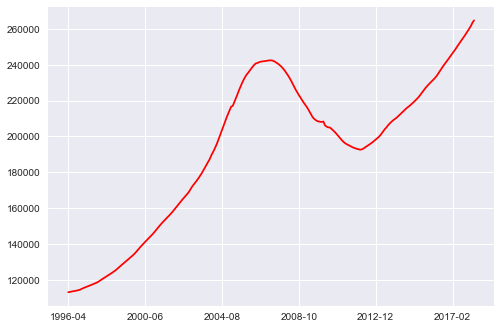

In [55]:
p2 = state_df.mean().plot(color='red')
p2

# Using Virginia as an example to figure out the process

In [ ]:
def melt_data(df):
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [36]:
va_df = state_df.iloc[45]
va_df = va_df.reset_index()
va_df.rename(columns={"index": "Date", "VA": "home_sales"}, inplace=True)
va_df['Date'] = pd.to_datetime(va_df['Date'])
va_df['home_sales'] = va_df['home_sales'].apply(lambda x: float("{:.2f}".format(x)))
va_df = va_df.set_index('Date')

In [62]:
va_df.head()

,home_sales
Date,
1996-04-01,122071.24
1996-05-01,122136.83
1996-06-01,122201.08
1996-07-01,122267.20
1996-08-01,122352.42


## Visualization

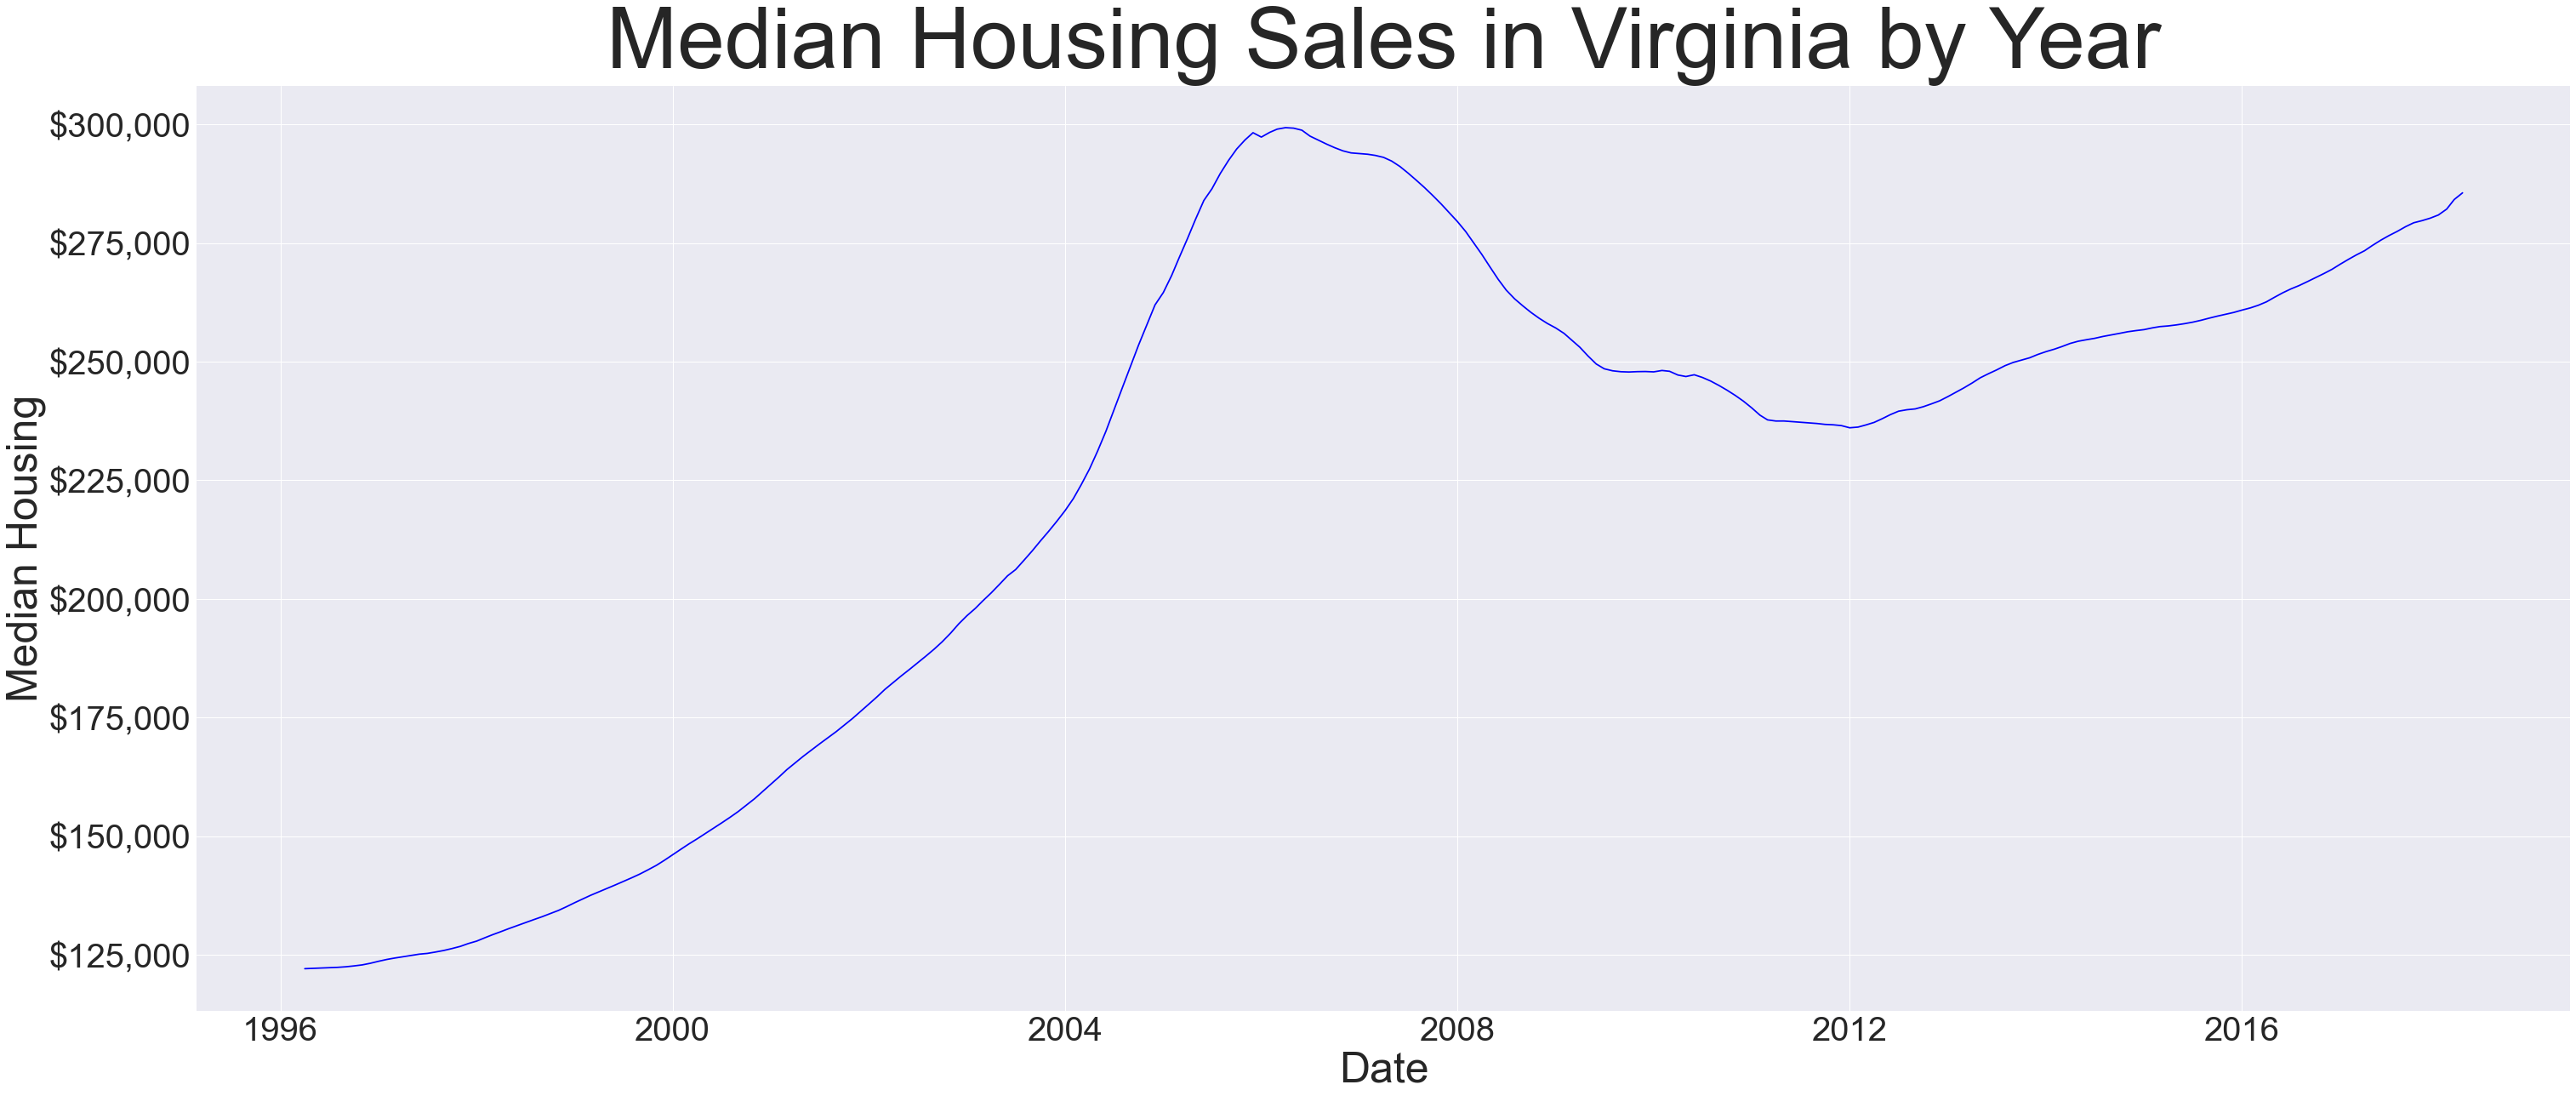

In [60]:
fig, ax = plt.subplots(figsize=(50, 20))
p = sns.lineplot(data=va_df, x='Date', y='home_sales', color='blue');

p.set_xlabel("Date", fontsize = 50)
p.set_ylabel("Median Housing", fontsize = 50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

p.set_title("Median Housing Sales in Virginia by Year", fontsize = 100)
plt.figsize=(50,25)

plt.show();

### Histogram (needs work)

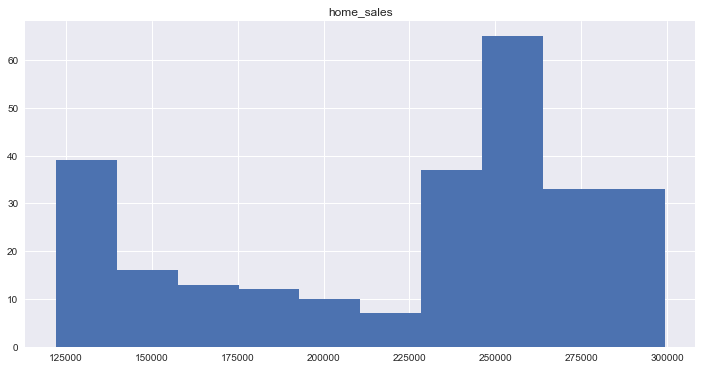

In [63]:
va_df.hist(figsize = (12,6))
plt.show()

### Density Plot

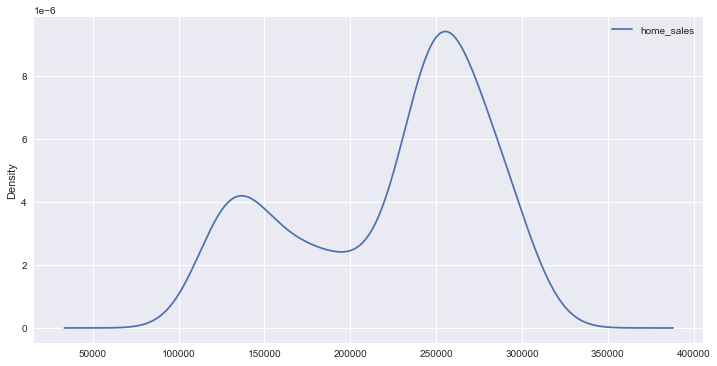

In [64]:
va_df.plot(kind='kde', figsize = (12,6))
plt.show()

In [69]:
# Determine rolling statistics
roll_mean = va_df.rolling(window=12, center=False).mean()
roll_std = va_df.rolling(window=12, center=False).std()

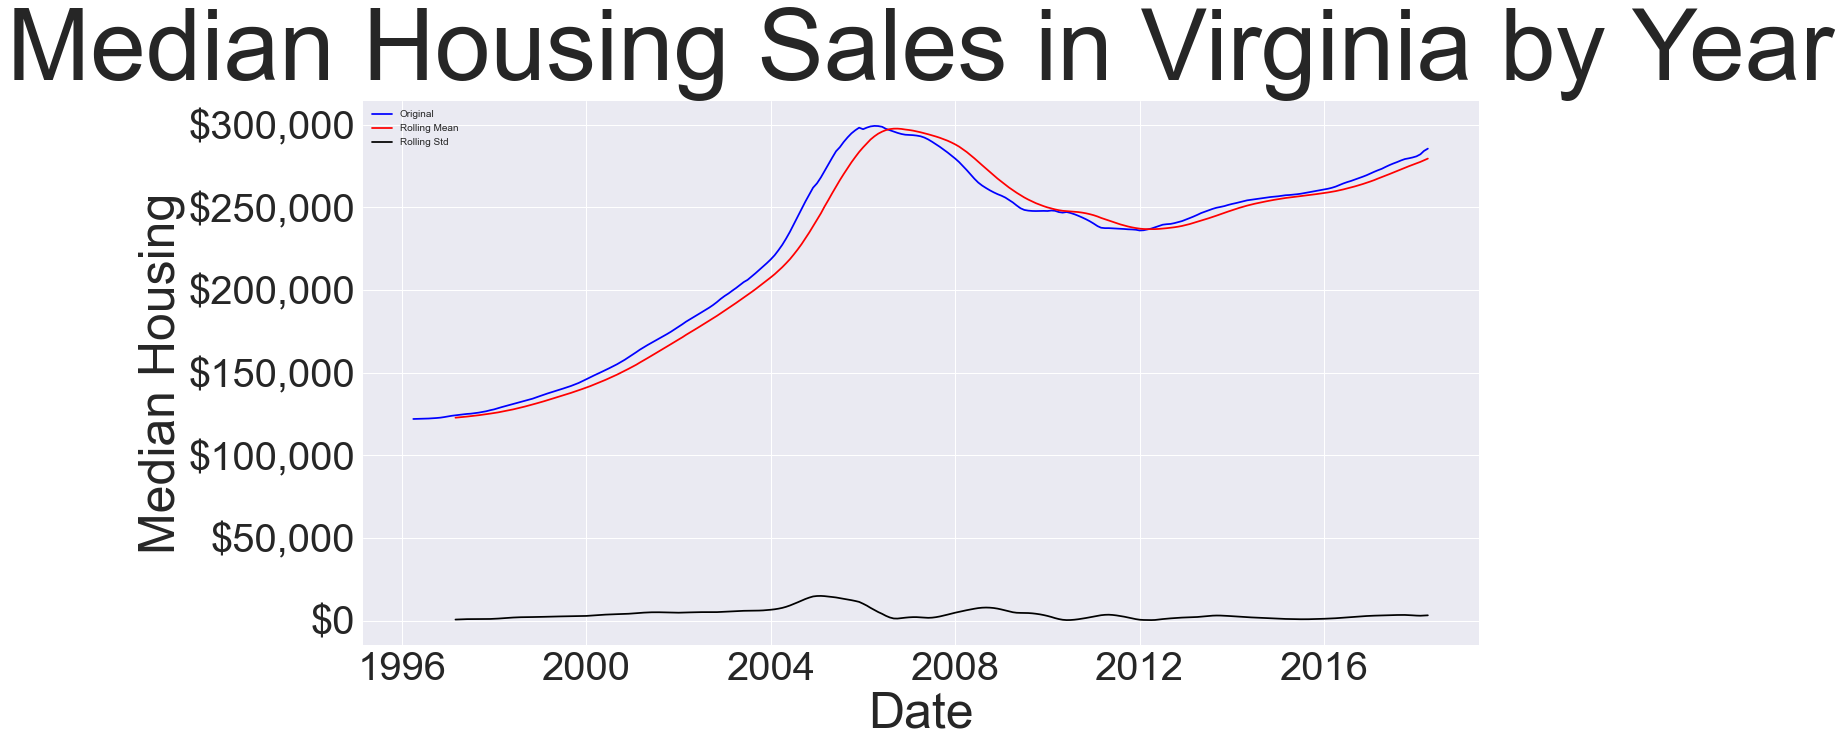

In [74]:
fig, ax = plt.subplots(figsize=(20, 10))
p = sns.lineplot(data=va_df, x='Date', y='home_sales', color='blue', label='Original');
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')

p.set_xlabel("Date", fontsize = 50)
p.set_ylabel("Median Housing", fontsize = 50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

p.set_title("Median Housing Sales in Virginia by Year", fontsize = 100)
plt.figsize=(50,25)
plt.legend(loc='best')

plt.show();

## Analysis:
- Mean increases over time and therefore is not stationary

## Dickey Fuller Test

In [75]:
from statsmodels.tsa.stattools import adfuller

# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
#dftest = adfuller(data['#Passengers'])
dftest = adfuller(va_df)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                  -1.730338
p-value                          0.415553
#Lags Used                      12.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


# Data DF

# Turn Code from Virginia into a fuction

In [ ]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [ ]:
va_df = state_df.iloc[45]
va_df = va_df.reset_index()
va_df.rename(columns={"index": "Date", "VA": "home_sales"}, inplace=True)
va_df['Date'] = pd.to_datetime(va_df['Date'])
va_df['home_sales'] = va_df['home_sales'].apply(lambda x: float("{:.2f}".format(x)))
va_df = va_df.set_index('Date')

In [42]:
state_df.head(2)

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
State,,,,,,,,,,,,,,,,,,,,,
AK,128382.142857,128832.142857,129253.571429,129639.285714,130028.571429,130367.857143,130710.714286,131085.714286,131557.142857,132107.142857,...,317921.428571,318610.714286,319382.142857,320185.714286,321378.571429,322657.142857,323775.00000,324167.857143,323692.857143,323046.428571
AL,86795.569620,87122.151899,87460.759494,87798.734177,88156.962025,88531.012658,88918.987342,89327.848101,89800.632911,90325.949367,...,149255.191257,149675.956284,150125.136612,150537.704918,150969.945355,151629.508197,152402.73224,153625.683060,155504.371585,157033.879781


In [46]:
state_df.iloc[:, 0]

State
AK    128382.142857
AL     86795.569620
AR     68868.041237
AZ    116202.790698
CA    200220.959596
CO    142561.943320
CT    157189.516129
DC    189216.666667
DE    125784.615385
FL    104529.019608
GA     95783.161512
HI    211811.764706
IA     78396.621622
ID     91951.578947
IL    127624.665392
IN     87843.112245
KS     77842.261905
KY     82155.000000
LA     65484.827586
MA    159684.541063
MD    146417.891374
ME     98218.181818
MI     92833.995585
MN     90961.918605
MO     91146.468401
MS     86397.014925
MT    157838.461538
NC     91146.019900
ND              NaN
NE     89468.571429
NH    107132.820513
NJ    175215.936255
NM    137096.226415
NV    153680.681818
NY    129927.512690
OH     88665.973535
OK     53432.380952
OR    124325.714286
PA     89103.011292
RI    125286.440678
SC     82504.687500
SD     54320.000000
TN     66087.468672
TX    109384.639831
UT    159645.689655
VA    122071.236559
VT     82825.000000
WA    140589.285714
WI    115151.376147
WV     66461.6

In [ ]:
state_df.apply(lambda x:  )

In [ ]:
def get_state_data(df):
    
    for row in df:
        temp_df = .reset_index()
va_df.rename(columns={"index": "Date", "VA": "home_sales"}, inplace=True)
va_df['Date'] = pd.to_datetime(va_df['Date'])
va_df['home_sales'] = va_df['home_sales'].apply(lambda x: float("{:.2f}".format(x)))
va_df = va_df.set_index('Date')

# New Archive - 5/2

## Attempting to slice out a zip code and test

In [ ]:
zip_test = data_df.iloc[0]

In [ ]:
zip_test

In [ ]:
zip_test = zip_test.reset_index()

In [ ]:
zip_test.head()

In [ ]:
zip_test.rename(columns={"index": "date"}, inplace=True)

In [ ]:
zip_test['date'] = pd.to_datetime(zip_test['date'])

In [ ]:
zip_test.head()

In [ ]:
zip_test = zip_test.set_index('date')

In [ ]:
zip_test.resample("Y").mean()

In [ ]:
zip_test.info()

In [ ]:
zip_test.drop([0])

In [ ]:
df.iloc[:, 7:].mean()

In [ ]:
df.describe()

## Finding Average Values

## Melting State_df and attempting to get all the states

In [ ]:
state_df.head()

In [ ]:
 #melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'],
 #   var_name='time')

In [ ]:
state_df

In [ ]:
state_melt_df = pd.melt(state_df)

In [ ]:
state_melt_df

### Need to change columns to datetime objects

In [ ]:
state_df.columns

In [ ]:
state_df.columns = get_datetimes(state_df)

In [ ]:
#state_df = state_df.reset_index()

In [ ]:
state_df.head()

In [ ]:
state_df.groupby('State').sum().mean()

## Feature Engineering: Adding Total Mean Value & Annual Mean Value

In [ ]:
#state_df['1996'] =
#state_df.apply(lambda x: x[''] / x[''], axis=1)
df['Fruit Total']= df.iloc[:, -4:-1].sum(axis=1)

In [ ]:
state_df.iloc[:, 22:34].head(3)

In [ ]:
#sum_1996 = state_df.iloc[:, 1:10].sum(axis=1)
#sum_1997 = state_df.iloc[:, 10:22].sum(axis=1)
#sum_1998 = state_df.iloc[:, 22:34].sum(axis=1)
#sum_1999 = state_df.iloc[:, 34:46].sum(axis=1)
#sum_2000 = state_df.iloc[:, 46:58].sum(axis=1)
#sum_2001 = state_df.iloc[:, 58:70].sum(axis=1)
#sum_2002 = state_df.iloc[:, 70:82].sum(axis=1)
#sum_2003 = state_df.iloc[:, 82:94].sum(axis=1)
#sum_2004 = state_df.iloc[:, 94:106].sum(axis=1)
#sum_2005 = state_df.iloc[:, 106:118].sum(axis=1)
#sum_2006 = state_df.iloc[:, 118:130].sum(axis=1)

In [ ]:
#state_df['RegionID'] = state_df['RegionID'].astype(object)

In [ ]:
# plot feature importance
#fig, ax = plt.subplots(figsize=(50,20))
#p = sns.barplot(data=feature_importance_df, x='Importance', y='Feature', color ='mediumseagreen' );
#p.set_xlabel("Importance", fontsize = 50)

#p.set_ylabel("Feature", fontsize = 50)
#plt.xticks(fontsize=40)
#plt.yticks(fontsize=40)

#p.set_title("Features by Importance", fontsize = 100)
#plt.figsize=(30,20) 
#plt.savefig('images/project_3_Feature_Importance')

#plt.show();

In [ ]:
fig, ax = plt.subplots(figsize=(50, 50))
p = sns.lineplot(data=state_df);
p.set_xlabel("State", fontsize = 50)
p.set_ylabel("Median Home Value", fontsize = 50)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

p.set_title("Title Goes Here", fontsize = 100)
plt.figsize=(50,25)

plt.show();

In [ ]:
state_df.mean().plot()

In [ ]:
df.reset_index()
df.head()

## Analysis of Categories

In [ ]:
#cat_df = df.iloc[:,0:7]
#cat_df.head()

In [ ]:
#cat_df.info()

In [ ]:
#cat_df['RegionName'] = cat_df['RegionName'].astype('object')
#cat_df.info()

In [ ]:
df.nunique()

In [ ]:
#print("RegionID unique values:", cat_df['RegionID'].nunique())
#print("RegionName unique values:", cat_df['RegionName'].nunique())
#print("City unique values:", cat_df['City'].nunique())
#print("State unique values:", cat_df['State'].nunique())
#print("Metro unique values:", cat_df['Metro'].nunique())
#print("CountyName unique values:", cat_df['CountyName'].nunique())
#print("SizeRank unique values:", cat_df['SizeRank'].nunique())

In [ ]:
#cat_df.sort_values(by = ['RegionName'], ascending = True).head()
df.sort_values(by = ['RegionName'], ascending = True).head()

A google search shows that RegionName is the ZipCode for each Region. However, upon sorting, I discovered that any ZipCode beginning with a 0 was ignoring it and displaying as a 4 digit number. I will use the .str().zfill() method to ensure that all RegionNames are displaying the as 5 digits.

In [ ]:
#cat_df['RegionName'] = cat_df['RegionName'].astype(str).str.zfill(5)
df['RegionName'] = df['RegionName'].astype(str).str.zfill(5)

In [ ]:
df.sort_values(by = ['RegionName'], ascending = True).head()

In [ ]:
#cat_df = cat_df.reset_index()
#cat_df

In [ ]:
#cat_df.sort_values(by = ['RegionName'], ascending = True).head()

That seems to have fixed it!

## Grouping Data

In [ ]:
metro_df = 

In [ ]:
melt_data(df)

## Analysis of Data Values

In [ ]:
#df['RegionID_copy'] = df['RegionID']

In [ ]:
#df.head()

In [ ]:
data_df = df.iloc[:, 7:]
data_df.head()

In [ ]:
data_df.columns = pd.to_datetime(data_df.columns, format='%Y-%m')
data_df.head()

In [ ]:
# changing values to thousands for ease of reading
data_df = data_df.applymap(lambda x: x/1000)
data_df.head()

In [ ]:
data_df.describe().round(2)

In [ ]:
#flipped_df = data_df.transpose()

In [ ]:
#flipped_df

In [ ]:
#flipped_df.info()

In [ ]:
#data_df.groupby(pd.Grouper(freq ='A'))

## Slicing out Years - data_df

In [ ]:
yr_1996 = data_df.iloc[:, :9]
yr_1996.head()

In [ ]:
yr_1997 = data_df.iloc[:, 9:21]
yr_1998 = data_df.iloc[:, 21:33]
yr_1999 = data_df.iloc[:, 33:45]

## CONTINUE TO SLICE OUT THE YEARS

In [ ]:
df.index

## EDA through Visualizations

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

In [ ]:
plt.gcf().autofmt_xdate()

In [ ]:
data_df.plot(figsize = (20,6), style = '.b');

## Melting Practice

In [ ]:
df.head(2)

In [ ]:
melt_test = df.iloc[:, :8]
melt_test.head()

In [ ]:
melt_data(melt_test)

In [ ]:
melted_df = melt_data(df)

In [ ]:
melted_df

## Merge Attempt

In [ ]:
#data_df = data_df.reset_index()

In [ ]:
#data_df

In [ ]:
#merged_df = cat_df.merge(data_df, on='index')

In [ ]:
#merged_df

## Slicing out Years and attempting to Melt - Full DF

In [ ]:
df.head()

In [ ]:
df.iloc[:, :16].head(2)

In [ ]:
yr_1996 = df.iloc[:, :16]
yr_1996.head()

In [ ]:
melt_data(yr_1996)

# Old Archive

In [ ]:
#data_df.isnull().sum()

In [ ]:
#df.columns[7:]

In [ ]:
#date_time_cols = pd.to_datetime(df.columns[7:])
#date_time_cols

In [ ]:
#cat_cols = df.columns[:7]
#cat_cols

In [ ]:
#new_cols = cat_cols + date_time_cols
#new_cols

In [ ]:
#df.rename(columns[7:] = date_time_cols)

## Exploring SizeRank

In [ ]:
df.sort_values('SizeRank').head()

In [ ]:
df.sort_values(by = ['State', 'City'], ascending = True)

In [ ]:
cat_data = df[['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']]

In [ ]:
cat_data

In [ ]:
df.head()

In [ ]:
date_data = df.drop(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)

In [ ]:
date_data.head()

In [ ]:
date_time_data = get_datetimes(date_data)

In [ ]:
date_time_data

In [ ]:
len(date_time_data)

In [ ]:
list(date_data.columns)

In [ ]:
#df2 = date_data.append(date_time_data)

## Changing column names to DateTime Format

In [ ]:
#df.columns = pd.to_datetime(df.columns)
date_data.columns = pd.to_datetime(date_data.columns)

In [ ]:
date_data

### Merging with Categories

In [ ]:
#imdb_df = pd.merge(table7, table4, on= 'tconst', how='inner')
base_df = pd.merge(cat_data, date_data, how='outer')

# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

## Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

### Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

## Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


## Step 1: Load the Data/Filtering for Chosen Zipcodes

## Step 2: Data Preprocessing

In [ ]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

## Step 3: EDA and Visualization

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

## Step 4: Reshape from Wide to Long Format

In [ ]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

## Step 5: ARIMA Modeling

## Step 6: Interpreting Results